In [1]:
import os
import numpy as np

In [2]:
import json
with open('eval_logs/run_009__20220403T190750.json') as json_file:
    data = json.load(json_file)
    print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
np.array(data['runs'][0]['coordinates']).shape # [number of envs; graph size; xy]

(8, 20, 2)

In [4]:
np.array(data['runs'][0]['tour_probs']).shape # [graph size; number of envs; graph size]

(20, 8, 20)

In [5]:
np.array(data['runs'][0]['tour_indices']).shape # [graph size; number of envs]

(20, 8)

In [6]:
all_coords = []
all_probs = []
all_tours = []
for i in range(len(data['runs'])):
    all_coords.append(data['runs'][i]['coordinates'])
    all_probs.append(data['runs'][i]['tour_probs'])
    all_tours.append(data['runs'][i]['tour_indices'])
    
all_coords = np.array(all_coords)
all_probs = np.array(all_probs).transpose(0, 2, 1, 3)
all_tours = np.array(all_tours).transpose(0, 2, 1)

all_coords = all_coords.reshape(all_coords.shape[0]*all_coords.shape[1], all_coords.shape[2], all_coords.shape[3])
all_probs = all_probs.reshape(all_probs.shape[0]*all_probs.shape[1], all_probs.shape[2], all_probs.shape[3])
all_tours = all_tours.reshape(all_tours.shape[0]*all_tours.shape[1], all_tours.shape[2])

In [7]:
all_coords.shape # .permute(1, 2, 3, 0, 4)

(800, 20, 2)

In [8]:
all_probs.shape

(800, 20, 20)

In [9]:
all_tours.shape

(800, 20)

In [10]:
all_probs[0][17]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.83862224e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.48534660e-09, 9.81613755e-01])

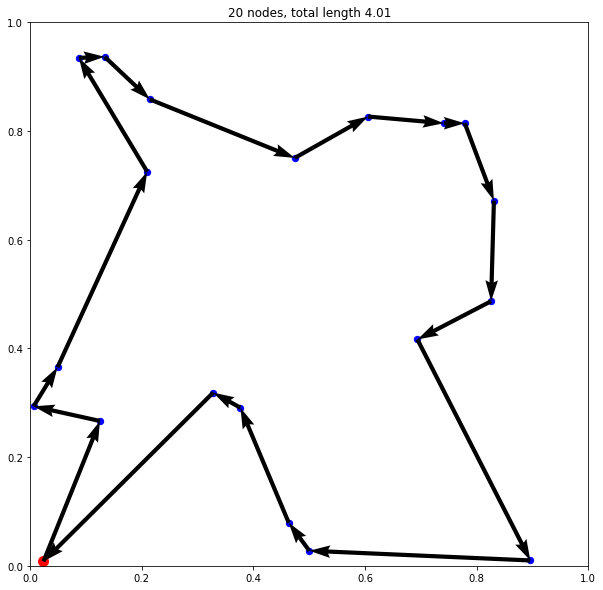

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1): # xy coordinates, tour indices, plot ref
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_idx = 18 # 13, 6, 14, 16
plot_tsp(all_coords[plot_idx], all_tours[plot_idx], ax)


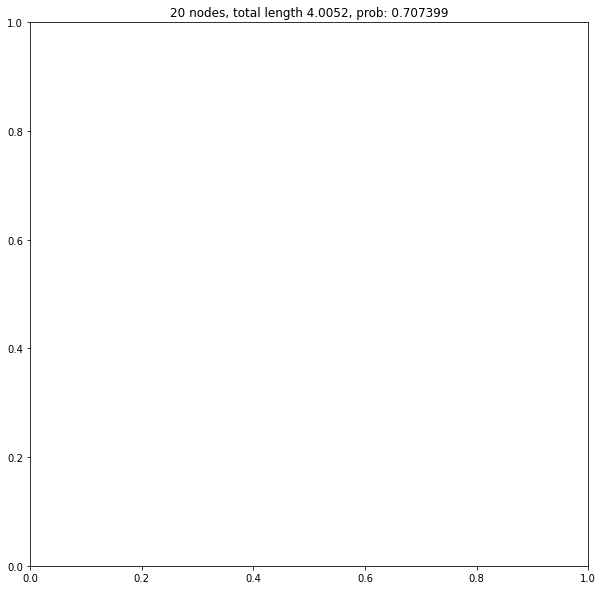

In [13]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000): # xy coordinates, tour indices, tour probabilities
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(all_coords[plot_idx], all_tours[plot_idx], all_probs[plot_idx]).animate(interval=500)
# animation.save('images/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick 
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
HTML(animation.to_html5_video())  # requires ffmpeg